In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
!pip install scikit-learn
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 9.2/9.2 MB 6.2 MB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)


# Read the data

In [2]:
#Read and transform data
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

X_train = train.drop(columns ='y')
y_train = train['y']

X_test = test.drop(columns ='y')
y_test = test['y']

#change the time here:

time = 5

# Regular simple model

In [3]:
lm = gp.Model()
num_features = X_train.shape[1] + 1
beta = lm.addMVar(num_features, lb=-np.inf)  


observations = X_train.shape[0]  

lm.setObjective(gp.quicksum(
    (beta[0] + gp.quicksum(beta[j+1] * X_train.iloc[i, j] for j in range(num_features - 1)) - y_train[i]) *
    (beta[0] + gp.quicksum(beta[j+1] * X_train.iloc[i, j] for j in range(num_features - 1)) - y_train[i])
    for i in range(observations)
))

lm.Params.OutputFlag = 0  # tell gurobi to shut up!!
lm.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20


In [4]:
lm.objVal

523.0149595263647

In [5]:
beta.x

array([ 0.96181997, -0.03124313,  0.10830046,  0.33658635,  0.34788706,
       -0.07805158, -0.26870205,  0.56917466, -0.09265014, -2.80170764,
        0.5961224 ,  0.00342708, -0.40802441,  0.64028772,  0.34250235,
       -0.35811603, -0.22662545,  0.47574886,  0.61818724,  0.5627165 ,
        0.91343131,  0.1266948 , -0.44072877, -1.13218924,  0.71016955,
        0.08281624, -1.48717747,  0.02439235, -0.38572888,  0.35864434,
        0.08111228, -0.18165492,  0.74866389, -0.04257738,  1.2137678 ,
       -0.53326153,  0.23934142,  0.25972978, -0.13112438, -1.09826371,
        0.45402031, -0.59555224,  0.33959881, -0.4208102 ,  0.04031396,
        1.8661944 , -0.01828012,  1.07420755,  0.147014  ,  0.56919769,
       -0.22109118])

# Gurobi Model

In [6]:
def gurobi(X,y,k):
    #Gurobi MIQP model
    lm = gp.Model()
    num_features = X.shape[1] + 1
    observations = X.shape[0]  

    beta = lm.addMVar(num_features, lb=-np.inf)  
    z = lm.addMVar(num_features, vtype='B')

    M = 138 #setting this as the sum of all highest values in x
    k = k

    lm.setObjective(gp.quicksum(
        (beta[0] + gp.quicksum(beta[j+1] * X.iloc[i, j] for j in range(num_features - 1)) - y[i]) *
        (beta[0] + gp.quicksum(beta[j+1] * X.iloc[i, j] for j in range(num_features - 1)) - y[i])
        for i in range(observations)
    ))

    for j in range(num_features - 1):
        lm.addConstr(beta[j + 1] <= M * z[j + 1])
        lm.addConstr(beta[j + 1] >= -M * z[j + 1])

    lm.addConstr(z.sum() <= k)

    lm.Params.OutputFlag = 0  # tell gurobi to shut up!!
    lm.Params.TimeLimit = time
    lm.optimize()
    
    return beta.x


def error(y_true, y_predict):
    #Sum of squared errors
    return sum((y_true - y_predict)**2)

def predict(X, betas):
    #Matrix multiplication between X and betas. Since betas has one value for intercept, adding betas[0] separate
    return X @ betas[1:] + betas[0]

In [7]:
gurobi(X_train,y_train,10)

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

# Gurobi with Cross Validation

In [8]:
num_samples = len(X_train)
k_folds = 10
k_folds_dict = {}

# Create 10 train-test splits
for i in range(k_folds):
    indices = np.arange(num_samples)
    np.random.seed(42)
    np.random.shuffle(indices)  # Random shuffle
    split_index = int(num_samples * 0.9)  # Set the train as 90%

    train_indices = indices[:split_index]  # 90% of data for training
    test_indices = indices[split_index:]  # 10% of data for testing

    index_dict = {
        'train_indices': train_indices,
        'test_indices': test_indices
    }
    k_folds_dict[i] = index_dict


In [9]:
#Here just creating an empty dictionary and setting the values for K
k_options = np.arange(5,51,5)

dict_gurobi = pd.DataFrame(index=k_folds_dict.keys(),columns=k_options)

for k_fold, indices_dict in k_folds_dict.items():

    # Get our training folds and testing folds
    X_train_fold = X_train.iloc[indices_dict['train_indices']]
    y_train_fold = y_train.iloc[indices_dict['train_indices']]

    X_test_fold = X_train.iloc[indices_dict['test_indices']]
    y_test_fold = y_train.iloc[indices_dict['test_indices']]
    
    X_train_fold.reset_index(drop=True, inplace=True)
    y_train_fold.reset_index(drop=True, inplace=True)
    
    X_test_fold.reset_index(drop=True, inplace=True)
    y_test_fold.reset_index(drop=True, inplace=True)

    # Now let's try out all of the possible k values
    for k in k_options:
        optimal_betas = gurobi(X_train_fold,y_train_fold,k)

        validation_mse = error(y_test_fold,predict(X_test_fold,optimal_betas))

        dict_gurobi.loc[k_fold,k] = validation_mse

dict_gurobi.to_csv('gurobi_error_results.csv',index=False)

dict_gurobi

,5,10,15,20,25,30,35,40,45,50
0,105.502243,75.159419,79.594713,75.431373,80.213236,76.238826,86.274678,88.048235,89.309151,89.027363
1,74.944402,73.177004,74.849565,82.109027,83.86702,88.311779,82.52042,84.365714,82.995938,83.135875
2,124.893908,79.810041,82.855982,84.604071,78.393683,84.152873,84.271027,89.71936,88.595578,89.518153
3,91.132889,76.132893,79.323073,84.118208,81.302433,78.744248,77.407272,75.506243,76.400727,76.280872
4,61.056586,50.786516,44.940572,49.193508,39.674736,41.088536,44.392446,47.75822,48.308163,48.03346
5,96.136439,79.772588,64.690549,63.657745,65.234597,70.217542,73.529266,71.77691,70.441992,70.44799
6,127.835689,94.369585,93.910987,90.123201,92.852781,90.543352,95.697752,93.193308,92.936657,93.000652
7,66.524048,52.617552,56.128105,54.234456,54.396602,57.827109,57.530103,59.940797,58.908477,59.488887
8,74.736541,71.205741,78.884039,83.690509,76.275999,77.847021,82.816094,78.590264,79.251896,79.395952
9,127.979037,104.587255,103.157133,121.500091,113.498847,115.1382,107.229227,108.409042,108.989415,108.326102


In [10]:
#Add the SSE for all folds for each K

sse_fold = dict_gurobi.sum()
sse_fold = pd.DataFrame(sse_fold,columns=['SSE'])
sse_fold

,SSE
5,950.741781
10,757.618593
15,758.334717
20,788.662189
25,765.709933
30,780.109487
35,791.668286
40,797.308093
45,796.137994
50,796.655306


Text(0, 0.5, 'SSE for all folds')

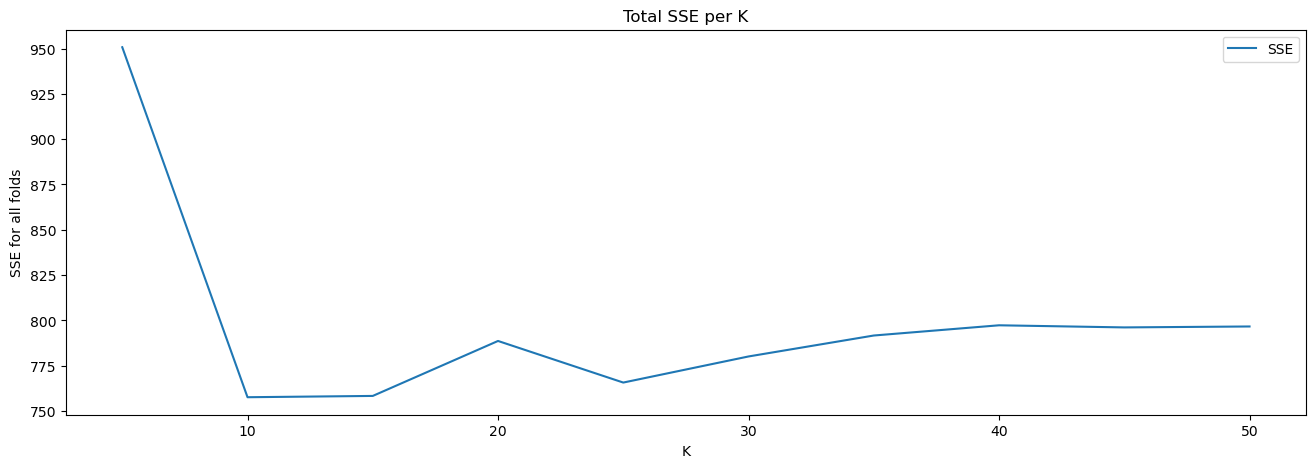

In [11]:
sse_fold.plot(figsize=(16,5))
plt.title('Total SSE per K')
plt.xlabel('K')
plt.ylabel('SSE for all folds')

In [12]:
#Let's save our best K here

best_k = sse_fold.astype(float).idxmin().values[0]
print(f'The best K is {best_k}')


The best K is 10


In [13]:
#Now let's run a Gurobi model using the best K

best_gurobi_betas = gurobi(X_train,y_train,best_k)
best_gurobi_prediction = predict(X_test,optimal_betas)
best_gurobi_error = error(y_test,best_gurobi_prediction)
best_gurobi_mse = mean_squared_error(y_test,best_gurobi_prediction)
best_gurobi_rsq = r2_score(y_test,best_gurobi_prediction)

print(f'The SSE for Gurobi with K = {best_k} is {best_gurobi_error:.2f}')
print(f'The MSE for Gurobi with K = {best_k} is {best_gurobi_mse:.2f}')
print(f'The R2 for Gurobi with K = {best_k} is {best_gurobi_rsq:.2f}')

The SSE for Gurobi with K = 10 is 121.42
The MSE for Gurobi with K = 10 is 2.43
The R2 for Gurobi with K = 10 is 0.85


# Lasso selecting lambda with sklearn

In [16]:
lasso_cv = linear_model.LassoCV(cv=10).fit(X_train,y_train)
best_lambda = lasso_cv.alpha_
print(f'The best lambda = {best_lambda}')

The best lambda = 0.07638765995113514


In [23]:
#Now create a Lasso model

lasso_model = Lasso(best_lambda).fit(X_train, y_train)

lasso_predictions = lasso_model.predict(X_test)
lasso_sse = error(y_test,lasso_predictions)
lasso_mse = mean_squared_error(y_test,lasso_predictions)
lasso_rsq = r2_score(y_test,lasso_predictions)

print(f'The SSE for Lasso with lambda = {best_lambda:.2f} is {lasso_sse:.2f}')
print(f'The MSE for Lasso with lambda = {best_lambda:.2f} is {lasso_mse:.2f}')
print(f'The RSQ for Lasso with lambda = {best_lambda:.2f} is {lasso_rsq:.2f}')

The SSE for Lasso with lambda = 0.08 is 117.48
The MSE for Lasso with lambda = 0.08 is 2.35
The RSQ for Lasso with lambda = 0.08 is 0.86


# Comparison between models

In [28]:
lasso_model.coef_

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.16054765,  0.        ,
       -0.05964031, -0.        , -0.        , -0.        , -0.41912484,
       -0.19325408,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.19517759, -1.36388738,  0.7425965 , -0.        ,
       -1.30481574, -0.        ,  0.        ,  0.05798283,  0.        ,
       -0.        ,  0.        , -0.09737839,  0.28341629,  0.        ,
        0.        ,  0.        ,  0.        , -0.23157873,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.03078191,  1.56362172,
       -0.02160033,  0.69992447, -0.09289745,  0.        ,  0.        ])

In [29]:
#Check the number of features selected with Lasso
(lasso_model.coef_ != 0).sum()

17

In [27]:
best_gurobi_betas[1:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -2.30820726,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.51832612,
       -0.20416201,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.55914318,  0.86697336,  0.        ,
       -1.31191942,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.4081653 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.78147489,
        0.        ,  0.88738292, -0.28229213,  0.        ,  0.        ])

In [30]:
#Check the number of features selected with MIQP
(best_gurobi_betas[1:] != 0).sum()

10